In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [3]:
df = pd.read_csv("prepped_df.csv", sep = ";")

In [4]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4811 entries, 0 to 4810
Data columns (total 20 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   team                                   4811 non-null   object 
 1   year                                   4811 non-null   int64  
 2   gender                                 4811 non-null   object 
 3   event_type                             4811 non-null   object 
 4   avg_age                                4811 non-null   float64
 5   gini                                   4811 non-null   float64
 6   events                                 4811 non-null   int64  
 7   points_sum                             4811 non-null   int64  
 8   population                             4811 non-null   float64
 9   gdp_per_capita                         4811 non-null   float64
 10  number_participants                    4811 non-null   int64  
 11  aver

In [5]:
df['event_type'] = df['gender'].apply(lambda x: 'Individual' if x == 'Individual Medley' else x)

In [8]:
# Define features (X) and target (y)
y = df['points_sum']
X = df.drop('points_sum', axis=1)

# Identify categorical and numerical features
categorical_features = ['team', 'gender', 'event_type']
# host_indicator is boolean, can be treated as numerical (0/1) or explicitly converted
X['host_indicator'] = X['host_indicator'].astype(int)

numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Ensure 'host_indicator' is treated as numerical if not already
if 'host_indicator' not in numerical_features:
    numerical_features.append('host_indicator')

# Create preprocessing pipelines for numerical and categorical features
numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ],
    remainder='passthrough' #  Keeps any columns not specified, though we've specified all
)

df.drop(columns=['team', 'year', 'relay_in_proportion', 'event_type'])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Create the full pipeline including preprocessing and the model
rf_benchmark_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('regressor', RandomForestRegressor(random_state=42))])

# Train the benchmark model
print("Training benchmark model...")
rf_benchmark_pipeline.fit(X_train, y_train)
print("Benchmark model training complete.")

# Make predictions
y_pred_benchmark = rf_benchmark_pipeline.predict(X_test)

# Evaluate the benchmark model
mse_benchmark = mean_squared_error(y_test, y_pred_benchmark)
rmse_benchmark = np.sqrt(mse_benchmark) # Calculate RMSE
r2_benchmark = r2_score(y_test, y_pred_benchmark)

print("\n--- Benchmark Random Forest Regressor ---")
print(f"Mean Squared Error (MSE): {mse_benchmark:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_benchmark:.4f}") # New
print(f"R-squared (R²): {r2_benchmark:.4f}")

Training benchmark model...
Benchmark model training complete.

--- Benchmark Random Forest Regressor ---
Mean Squared Error (MSE): 5.5633
Root Mean Squared Error (RMSE): 2.3587
R-squared (R²): 0.7913


In [12]:
# Define the parameter grid for GridSearchCV
# These are just example parameters; you might want to adjust them
# Consider a smaller grid initially to speed up testing
param_grid = {
    'regressor__n_estimators': [250],         # Reduced for quicker run
    'regressor__max_depth': [20],             #
    'regressor__min_samples_split': [2],
    'regressor__min_samples_leaf': [1],
    'regressor__max_features': ['sqrt']
}

# Create the pipeline for the tuned model
rf_tuned_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('regressor', RandomForestRegressor(random_state=42))])

# Create GridSearchCV object
# cv=3 means 3-fold cross-validation.
# For actual tuning, you might increase cv (e.g., to 5 or 10) and expand param_grid
grid_search = GridSearchCV(rf_tuned_pipeline, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           verbose=1, n_jobs=-1)

# Fit GridSearchCV
print("\nStarting GridSearchCV for hyperparameter tuning...")
grid_search.fit(X_train, y_train)
print("GridSearchCV training complete.")

# Get the best estimator
best_rf_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred_tuned = best_rf_model.predict(X_test)

# Evaluate the tuned model
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mse_tuned) # Calculate RMSE
r2_tuned = r2_score(y_test, y_pred_tuned)

print("\n--- Tuned Random Forest Regressor ---")
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Mean Squared Error (MSE): {mse_tuned:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_tuned:.4f}") # New
print(f"R-squared (R²): {r2_tuned:.4f}")

# Compare with benchmark
print("\n--- Comparison ---")
print(f"Benchmark Model MSE: {mse_benchmark:.4f}, RMSE: {rmse_benchmark:.4f}, R²: {r2_benchmark:.4f}")
print(f"Tuned Model MSE: {mse_tuned:.4f}, RMSE: {rmse_tuned:.4f}, R²: {r2_tuned:.4f}")


Starting GridSearchCV for hyperparameter tuning...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
GridSearchCV training complete.

--- Tuned Random Forest Regressor ---
Best Hyperparameters: {'regressor__max_depth': 20, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 250}
Mean Squared Error (MSE): 4.9833
Root Mean Squared Error (RMSE): 2.2323
R-squared (R²): 0.8131

--- Comparison ---
Benchmark Model MSE: 5.5633, RMSE: 2.3587, R²: 0.7913
Tuned Model MSE: 4.9833, RMSE: 2.2323, R²: 0.8131


C:\Users\jakub\AppData\Local\Temp\ipykernel_7204\861663646.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, color='red', label='Perfect Prediction')


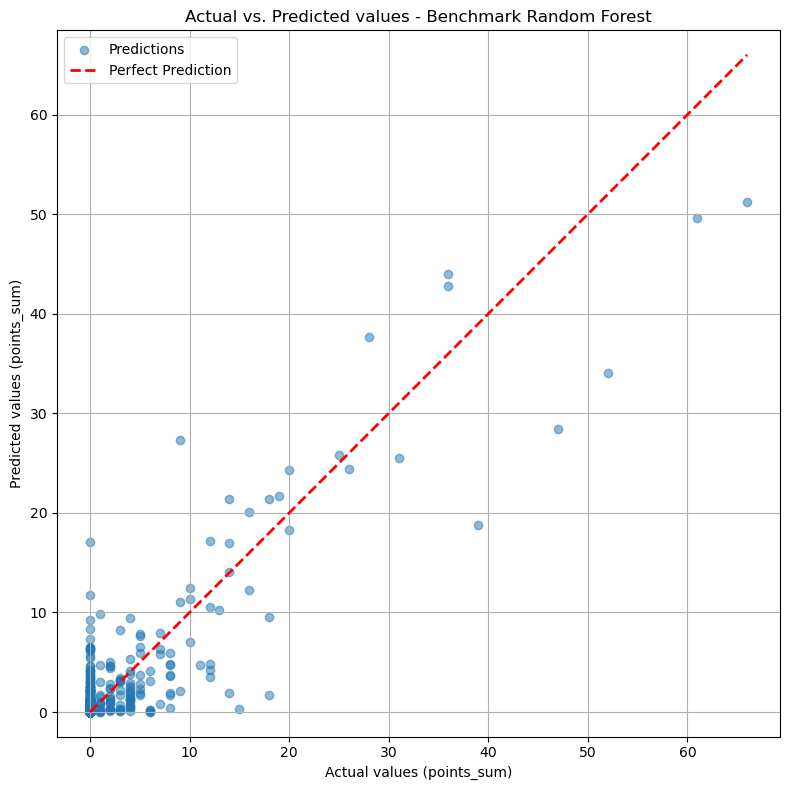

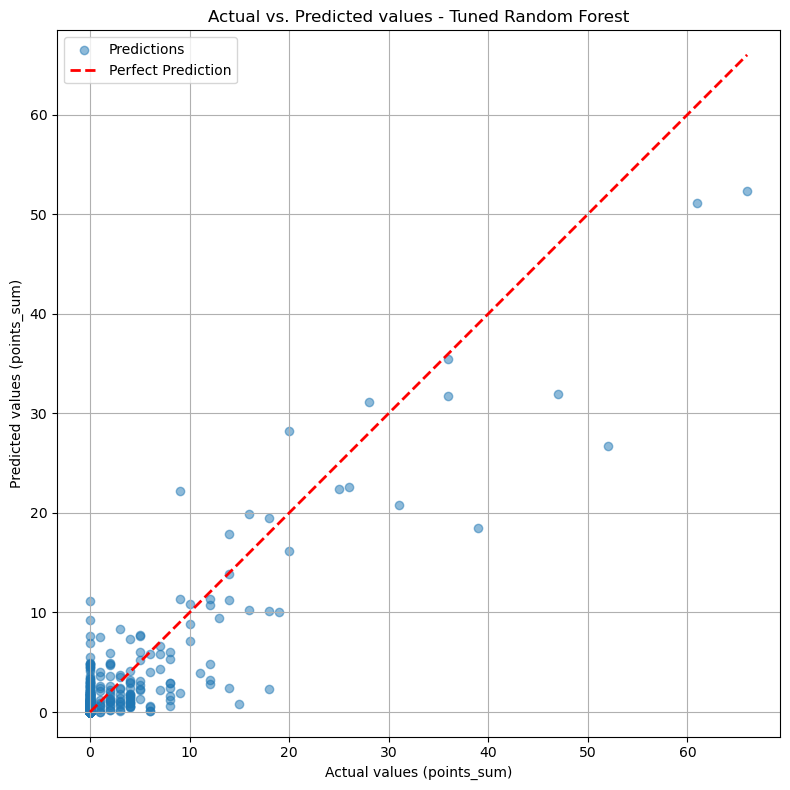

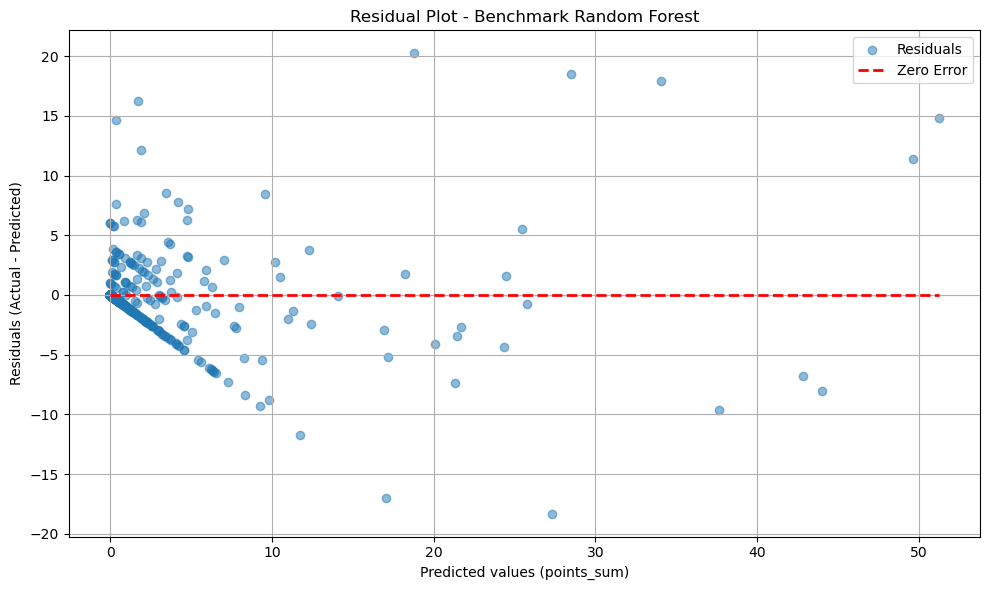

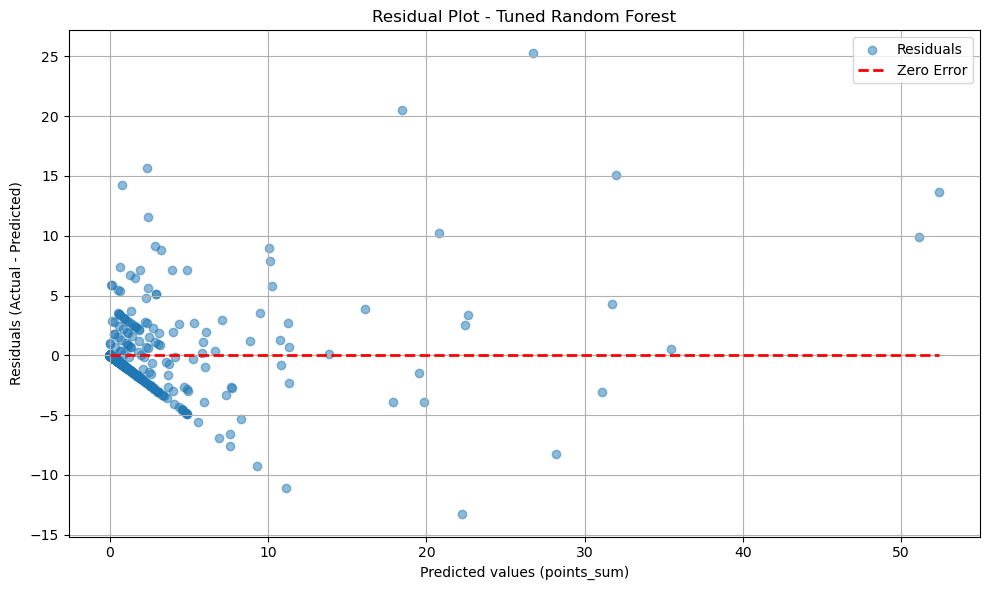

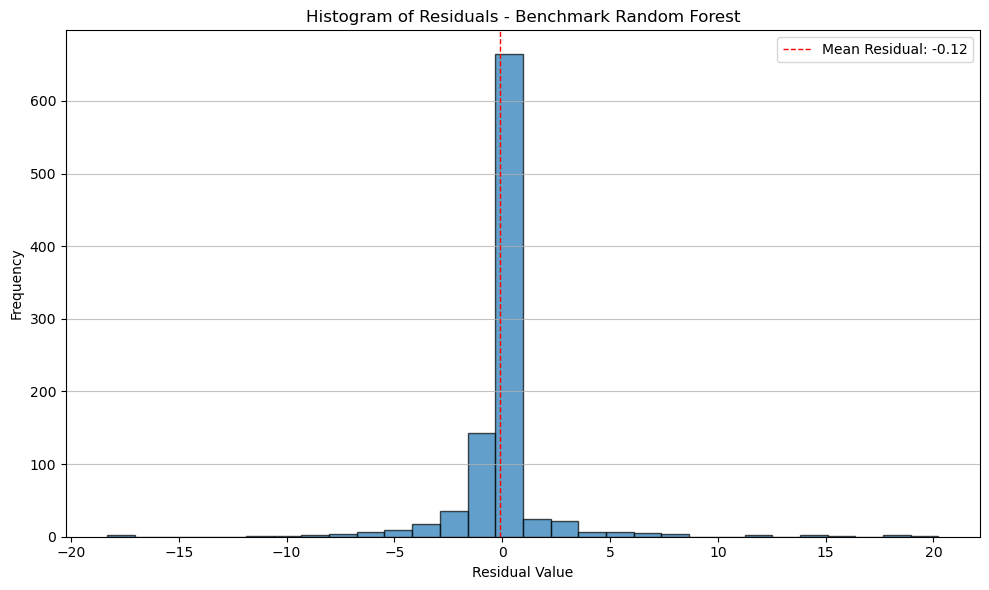

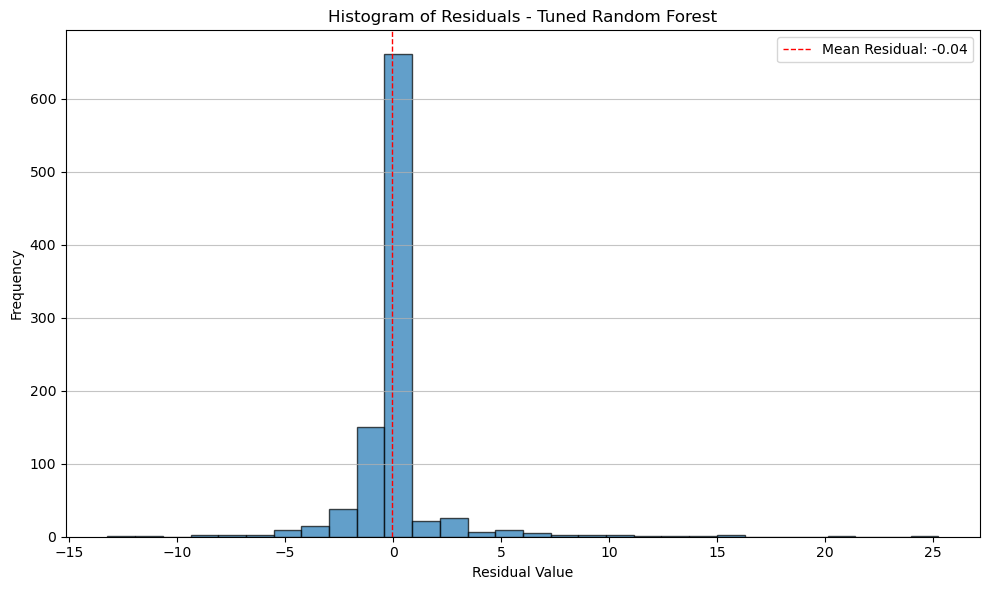

In [13]:
import matplotlib.pyplot as plt
import numpy as np # We'll use this for the diagonal line

# Ensure you have these variables from your previous model training and prediction steps:
# y_test: The true values for the test set
# y_pred_benchmark: Predictions from your benchmark Random Forest model
# y_pred_tuned: Predictions from your tuned Random Forest model

# --- 1. Actual vs. Predicted Plot ---

def plot_actual_vs_predicted(y_true, y_pred, model_name="Model"):
    """Generates an Actual vs. Predicted scatter plot."""
    plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred, alpha=0.5, label='Predictions')
    
    # Line for perfect prediction
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, color='red', label='Perfect Prediction')
    
    plt.xlabel("Actual values (points_sum)")
    plt.ylabel("Predicted values (points_sum)")
    plt.title(f"Actual vs. Predicted values - {model_name}")
    plt.legend()
    plt.grid(True)
    plt.axis('equal') # Ensures the x and y axes have the same scale for a proper 45-degree line
    plt.tight_layout()
    plt.show()

# Generate plots for both models
plot_actual_vs_predicted(y_test, y_pred_benchmark, model_name="Benchmark Random Forest")
plot_actual_vs_predicted(y_test, y_pred_tuned, model_name="Tuned Random Forest")


# --- 2. Residual Plot ---

def plot_residuals(y_true, y_pred, model_name="Model"):
    """Generates a Residual Plot (Predicted vs. Residuals)."""
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.5, label='Residuals')
    
    # Line at y=0
    plt.hlines(0, xmin=y_pred.min(), xmax=y_pred.max(), colors='red', linestyles='--', lw=2, label='Zero Error')
    
    plt.xlabel("Predicted values (points_sum)")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.title(f"Residual Plot - {model_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Generate residual plots for both models
plot_residuals(y_test, y_pred_benchmark, model_name="Benchmark Random Forest")
plot_residuals(y_test, y_pred_tuned, model_name="Tuned Random Forest")

# --- Optional: Histogram of Residuals ---
# This helps to see if the residuals are normally distributed,
# which is an assumption for some statistical inferences (though not strictly required for RF to work).

def plot_residual_histogram(y_true, y_pred, model_name="Model", bins=30):
    """Generates a histogram of the residuals."""
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=bins, edgecolor='black', alpha=0.7)
    plt.axvline(residuals.mean(), color='red', linestyle='dashed', linewidth=1, label=f'Mean Residual: {residuals.mean():.2f}')
    plt.xlabel("Residual Value")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of Residuals - {model_name}")
    plt.legend()
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    plt.show()

plot_residual_histogram(y_test, y_pred_benchmark, model_name="Benchmark Random Forest")
plot_residual_histogram(y_test, y_pred_tuned, model_name="Tuned Random Forest")

In [14]:
# Assuming 'best_rf_model' is your pipeline from GridSearchCV
# and 'preprocessor' is your ColumnTransformer object

# Get the Random Forest regressor step
rf_regressor = best_rf_model.named_steps['regressor']

# Get feature names after one-hot encoding
# This can be a bit tricky with ColumnTransformer but is doable
try:
    onehot_feature_names = best_rf_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
    all_feature_names = numerical_features + list(onehot_feature_names)

    importances = rf_regressor.feature_importances_
    feature_importance_df = pd.DataFrame({'feature': all_feature_names, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
    print("\n--- Feature Importances (from tuned model) ---")
    print(feature_importance_df.head(20)) # Print top 20
except Exception as e:
    print(f"Could not retrieve feature names for importance: {e}")
    print("Feature importances (indices):", rf_regressor.feature_importances_)


--- Feature Importances (from tuned model) ---
                                   feature  importance
6                      number_participants    0.120758
9                          total_freestyle    0.115318
192                               team_USA    0.114560
10                            total_medley    0.106184
3                                   events    0.102284
4                               population    0.076093
13   proportion_participants_to_population    0.049502
7                   average_total_distance    0.044135
5                           gdp_per_capita    0.039605
2                                     gini    0.030112
1                                  avg_age    0.030092
0                                     year    0.028636
14                     relay_in_proportion    0.021372
8                          total_butterfly    0.021222
12                        total_backstroke    0.019396
11                      total_breaststroke    0.019207
25               